In [1]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/colab_setup.sh -O - | bash

--2021-10-06 10:34:15--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-10-06 10:34:15 (36.4 MB/s) - written to stdout [1608/1608]

setup Colab for PySpark 3.0.2 and Spark NLP 3.1.0
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubun

In [2]:
import sparknlp
spark= sparknlp.start()

In [3]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import pandas as pd
from pyspark.ml import Pipeline
from sparknlp.pretrained import *
from sklearn.metrics import classification_report

In [4]:
from sparknlp.training import CoNLL

In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [6]:
with open("eng.train") as f:
  train_txt= f.read()

print(train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


In [7]:
training_data= CoNLL().readDataset(spark, "eng.train")
training_data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[[document, 0, 47...|[[document, 0, 47...|[[token, 0, 1, EU...|[[pos, 0, 1, NNP,...|[[named_entity, 0...|
|     Peter Blackburn|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 4, Pe...|[[pos, 0, 4, NNP,...|[[named_entity, 0...|
| BRUSSELS 1996-08-22|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 7, BR...|[[pos, 0, 7, NNP,...|[[named_entity, 0...|
|The European Comm...|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 2, Th...|[[pos, 0, 2, DT, ...|[[named_entity, 0...|
|Germany 's repres...|[[document, 0, 21...|[[document, 0, 21...|[[token, 0, 6, Ge...|[[pos, 0, 6, NNP,..

In [9]:
training_data.select(F.explode(F.arrays_zip("token.result", "pos.result", "label.result")).alias("col"))\
    .select(F.expr("col['0']").alias("token"),
            F.expr("col['1']").alias("pos"),
            F.expr("col['2']").alias("label")).show(truncate=False)

+----------+---+------+
|token     |pos|label |
+----------+---+------+
|EU        |NNP|B-ORG |
|rejects   |VBZ|O     |
|German    |JJ |B-MISC|
|call      |NN |O     |
|to        |TO |O     |
|boycott   |VB |O     |
|British   |JJ |B-MISC|
|lamb      |NN |O     |
|.         |.  |O     |
|Peter     |NNP|B-PER |
|Blackburn |NNP|I-PER |
|BRUSSELS  |NNP|B-LOC |
|1996-08-22|CD |O     |
|The       |DT |O     |
|European  |NNP|B-ORG |
|Commission|NNP|I-ORG |
|said      |VBD|O     |
|on        |IN |O     |
|Thursday  |NNP|O     |
|it        |PRP|O     |
+----------+---+------+
only showing top 20 rows



In [10]:
training_data.select(F.explode(F.arrays_zip("token.result", "label.result")).alias("col"))\
    .select(F.expr("col['0']").alias("token"),
            F.expr("col['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show()

+------------+------+
|ground_truth| count|
+------------+------+
|           O|169578|
|       B-LOC|  7140|
|       B-PER|  6600|
|       B-ORG|  6321|
|       I-PER|  4528|
|       I-ORG|  3704|
|      B-MISC|  3438|
|       I-LOC|  1157|
|      I-MISC|  1155|
+------------+------+



In [11]:
word_embedding= WordEmbeddingsModel.pretrained("glove_100d")\
    .setInputCols(["document", "token"])\
    .setOutputCol("embedding")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
!mkdir ner_logs

In [12]:
nerTagger= NerDLApproach()\
    .setInputCols(["sentence", "token", "embedding"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(1)\
    .setLr(0.003)\
    .setBatchSize(32)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True)\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath("ner_logs")

In [13]:
ner_pipeline= Pipeline(stages= [word_embedding, nerTagger])

In [14]:
%%time
ner_model= ner_pipeline.fit(training_data)

CPU times: user 871 ms, sys: 92.9 ms, total: 963 ms
Wall time: 2min 55s


In [15]:
!cd ner_logs && ls -lt

total 4
-rw-r--r-- 1 root root 1013 Oct  6 10:53 NerDLApproach_10c69d44b964.log


In [17]:
!head -n 45 ner_logs/NerDLApproach_10c69d44b964.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11223


Epoch 1/1 started, lr: 0.003, dataset size: 11223


Epoch 1/1 - 117.64s - loss: 1145.4164 - batches: 353
Quality on validation dataset (20.0%), validation examples = 2244
time to finish evaluation: 12.69s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 1358	 105	 129	 0.9282297	 0.9132481	 0.9206779
I-ORG	 605	 106	 173	 0.8509142	 0.777635	 0.81262594
I-MISC	 133	 25	 114	 0.84177214	 0.53846157	 0.65679014
I-LOC	 202	 52	 38	 0.79527557	 0.84166664	 0.8178138
I-PER	 890	 70	 10	 0.9270833	 0.98888886	 0.9569892
B-MISC	 554	 96	 131	 0.8523077	 0.80875915	 0.82996255
B-ORG	 1126	 215	 155	 0.8396719	 0.8790008	 0.85888636
B-PER	 1263	 107	 63	 0.9218978	 0.95248866	 0.9369436
tp: 6131 fp: 776 fn: 813 labels: 8
Macro-average	 prec: 0.8696441, rec: 0.8375186, f1: 0.85327905
Micro-average	 prec: 0.8876502, rec: 0.8829205, 

In [18]:
test_data= CoNLL().readDataset(spark, "eng.testa")
test_data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[[document, 0, 64...|[[document, 0, 64...|[[token, 0, 6, CR...|[[pos, 0, 6, NNP,...|[[named_entity, 0...|
|   LONDON 1996-08-30|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 5, LO...|[[pos, 0, 5, NNP,...|[[named_entity, 0...|
|West Indian all-r...|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 3, We...|[[pos, 0, 3, NNP,...|[[named_entity, 0...|
|Their stay on top...|[[document, 0, 20...|[[document, 0, 20...|[[token, 0, 4, Th...|[[pos, 0, 4, PRP$...|[[named_entity, 0...|
|After bowling Som...|[[document, 0, 21...|[[document, 0, 21...|[[token, 0, 4, Af...|[[pos, 0, 4, IN, ..

In [19]:
test_data.select(F.explode(F.arrays_zip("token.result", "label.result")).alias("col"))\
    .select(F.expr("col['0']").alias("token"),
            F.expr("col['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show()

+------------+-----+
|ground_truth|count|
+------------+-----+
|           O|42759|
|       B-PER| 1842|
|       B-LOC| 1837|
|       B-ORG| 1341|
|       I-PER| 1307|
|      B-MISC|  922|
|       I-ORG|  751|
|      I-MISC|  346|
|       I-LOC|  257|
+------------+-----+



In [21]:
predictions= ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|           embedding|                 ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[[document, 0, 64...|[[document, 0, 64...|[[token, 0, 6, CR...|[[pos, 0, 6, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[named_entity, 0...|
|   LONDON 1996-08-30|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 5, LO...|[[pos, 0, 5, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[named_entity, 0...|
|West Indian all-r...|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 3, We...|[[pos, 0, 3, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[

In [22]:
predictions.select(F.explode(F.arrays_zip("token.result", "label.result", "ner.result")).alias("col"))\
    .select(F.expr("col['0']").alias("token"),
            F.expr("col['1']").alias("ground_truth"),
            F.expr("col['2']").alias("ner_label")).show(truncate=False)

+--------------+------------+---------+
|token         |ground_truth|ner_label|
+--------------+------------+---------+
|CRICKET       |O           |O        |
|-             |O           |O        |
|LEICESTERSHIRE|B-ORG       |B-ORG    |
|TAKE          |O           |O        |
|OVER          |O           |O        |
|AT            |O           |O        |
|TOP           |O           |O        |
|AFTER         |O           |O        |
|INNINGS       |O           |O        |
|VICTORY       |O           |O        |
|.             |O           |O        |
|LONDON        |B-LOC       |B-LOC    |
|1996-08-30    |O           |O        |
|West          |B-MISC      |B-MISC   |
|Indian        |I-MISC      |I-MISC   |
|all-rounder   |O           |O        |
|Phil          |B-PER       |B-PER    |
|Simmons       |I-PER       |I-PER    |
|took          |O           |O        |
|four          |O           |O        |
+--------------+------------+---------+
only showing top 20 rows



In [23]:
from sklearn.metrics import classification_report

In [ ]:
pred_df= predictions.select(F.explode(F.arrays_zip("token.result", "label.result", "ner.result")).alias("col"))\
    .select(F.expr("col['0']").alias("token"),
            F.expr("col['1']").alias("ground_truth"),
            F.expr("col['2']").alias("prediction")).toPandas()

In [ ]:
print(classification_report(pred_df["ground_truth"], pred_df["prediction"]))

              precision    recall  f1-score   support

       B-LOC       0.91      0.92      0.91      1837
      B-MISC       0.93      0.79      0.85       922
       B-ORG       0.82      0.87      0.85      1341
       B-PER       0.94      0.96      0.95      1842
       I-LOC       0.85      0.72      0.78       257
      I-MISC       0.82      0.57      0.67       346
       I-ORG       0.78      0.77      0.77       751
       I-PER       0.97      0.96      0.97      1307
           O       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.89      0.84      0.86     51362
weighted avg       0.98      0.98      0.98     51362



In [24]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

In [25]:
import ner_log_parser

In [26]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

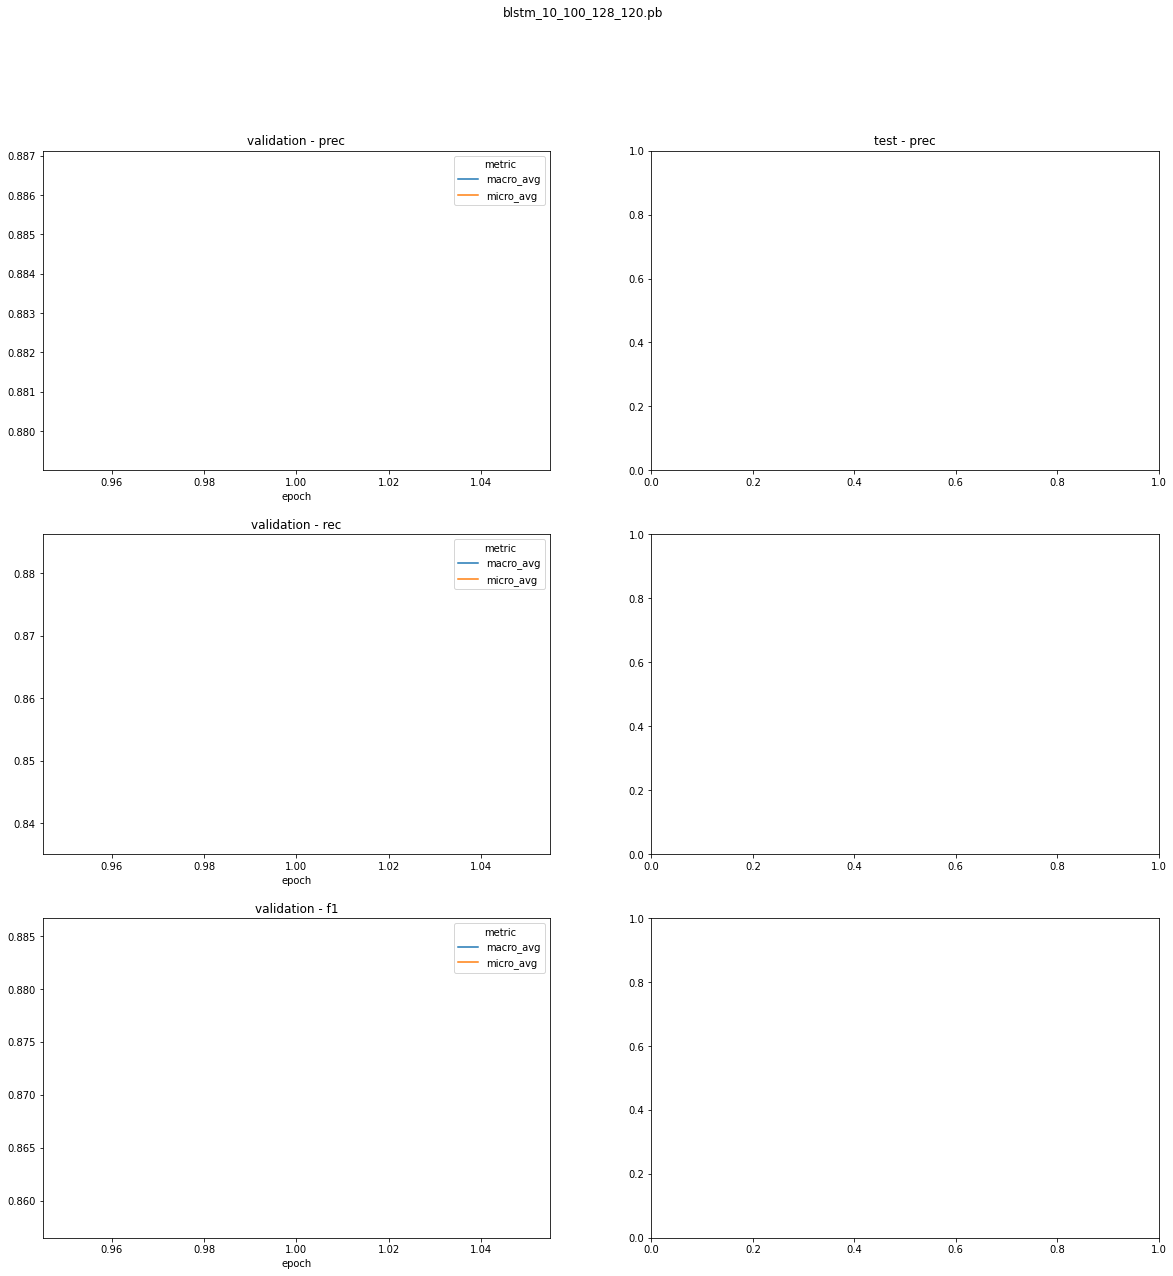

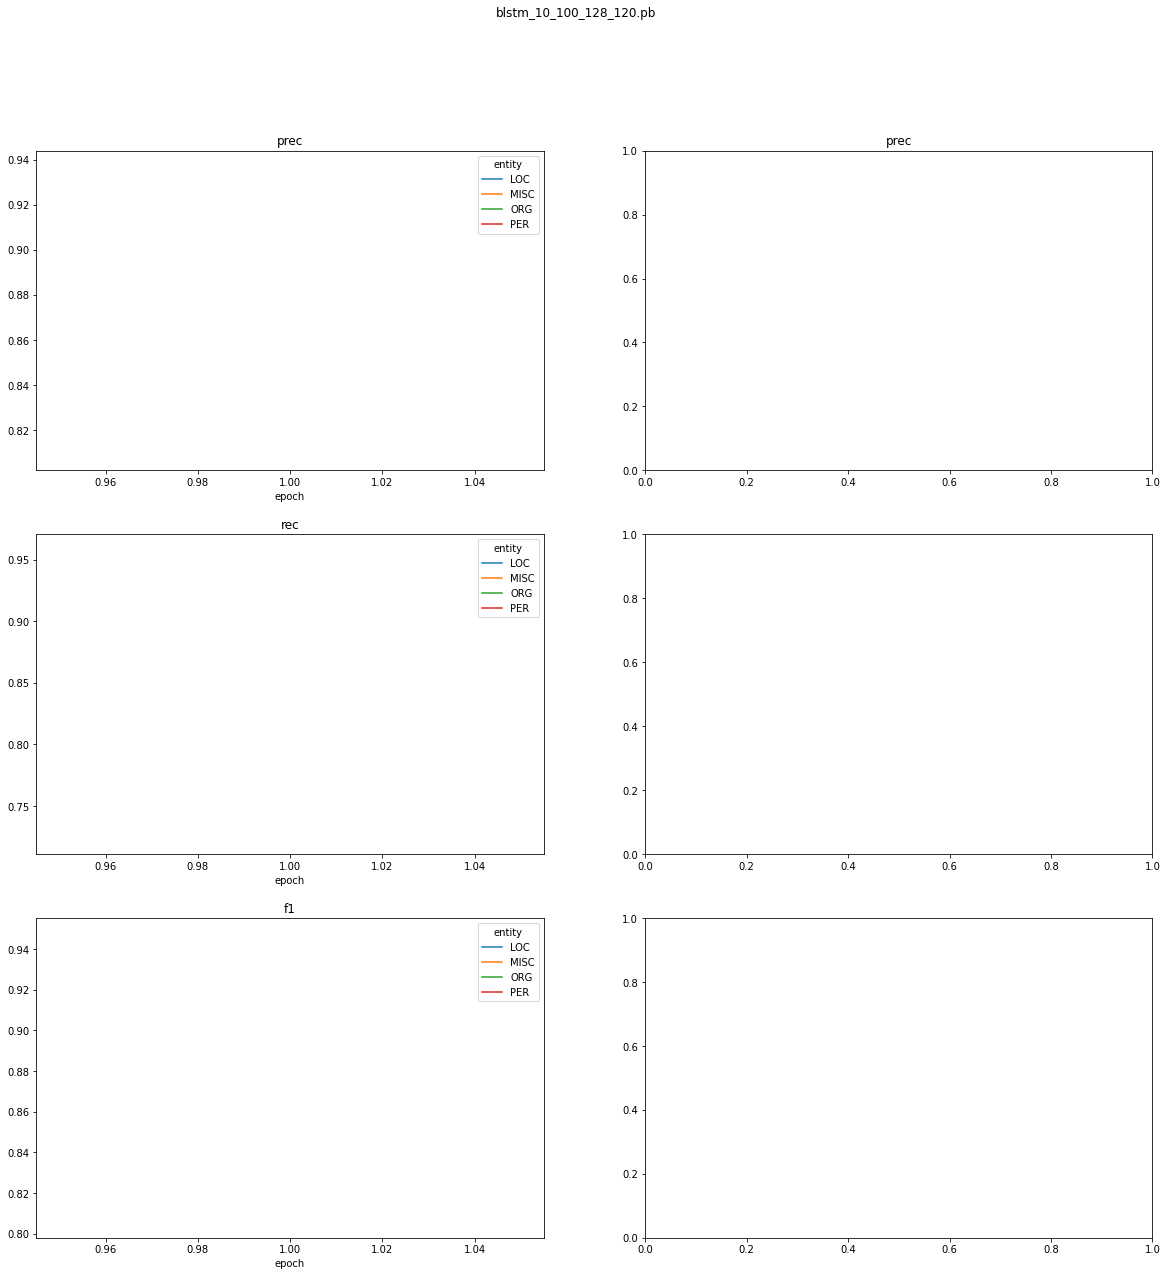

In [ ]:
ner_log_parser.get_charts("/content/ner_logs/NerDLApproach_c308e0c0f8f0.log")

## Saving the model

In [28]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_bbfd9ac373b2]

In [29]:
ner_model.stages[1].write().overwrite().save("Ner_with_glove")

In [30]:
!ls -lt

total 4040
drwxr-xr-x 4 root root    4096 Oct  6 11:03 Ner_with_glove
drwxr-xr-x 2 root root    4096 Oct  6 11:01 __pycache__
-rw-r--r-- 1 root root    3826 Oct  6 11:01 ner_log_parser.py
drwxr-xr-x 2 root root    4096 Oct  6 10:51 ner_logs
-rw-r--r-- 1 root root  827443 Oct  6 10:38 eng.testa
-rw-r--r-- 1 root root 3283420 Oct  6 10:38 eng.train
drwxr-xr-x 1 root root    4096 Sep 30 17:12 sample_data


## Prediction Pipeline

In [40]:
documentAssembler= DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence= SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

token= Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

word_embedding= WordEmbeddingsModel.pretrained("glove_100d")\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

loaded_ner_model= NerDLModel.load("/content/Ner_with_glove")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter= NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_chunk")

pipeline= Pipeline(stages=[ 
                           documentAssembler,
                           sentence,
                           token,
                           word_embedding,
                           loaded_ner_model,
                           ner_converter
])

empty_df= spark.createDataFrame([[" "]]).toDF("text")
model= pipeline.fit(empty_df)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [50]:
text= "If I would have chance to go to NY, i would go to Pink Floyd concert in Madison Square Garden. "
spark_df= spark.createDataFrame([[text]]).toDF("text")
spark_df.show()

+--------------------+
|                text|
+--------------------+
|If I would have c...|
+--------------------+



In [51]:
predictions= model.transform(spark_df)

In [52]:
predictions.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|If I would have c...|[[document, 0, 94...|[[document, 0, 93...|[[token, 0, 1, If...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 32, 33, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [1]:
predictions.select(F.explode(F.arrays_zip("ner_chunk.result", "ner_chunk.metadata")).alias("entities"))\
    .select(F.expr("entities['0']").alias("ner_chunk"),
            F.expr("entities['1'].entity").alias("ner_label")).show(truncate=False)

NameError: ignored